In [2]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [3]:
# Dictionary for emotion mapping based on filename structure
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


In [4]:
# Path to spectrogram images
path_to_save_spectrograms = 'C://Users//tatba//Downloads//Speech_Emotion_Detection(RCCIIT)//Speech_Emotion_Detection(RCCIIT) (2)//Speech_Emotion_Detection(RCCIIT)//Speech Emotion Detection//path_to_save_spectrograms'

In [5]:
# Image parameters
img_height, img_width = 128, 128

In [6]:
# Load images and labels from filenames
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            # Load image manually using cv2
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (img_width, img_height))
            img_array = img / 255.0  # Normalize
            images.append(img_array)
            # Extract emotion from filename (3rd element in the filename)
            emotion_code = filename.split('-')[2]
            emotion_label = emotions[emotion_code]
            labels.append(emotion_label)
    return np.array(images), np.array(labels)

In [7]:
# Load the dataset
X, y = load_data(path_to_save_spectrograms)

In [8]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [10]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=8)

In [11]:
# Load pre-trained VGG16 model without the top classification layer
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x)  # 8 classes for the 8 emotions

# Create the model
model = Model(inputs=base_model.input, outputs=x)

In [12]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 966ms/step - accuracy: 0.1821 - loss: 2.5849 - val_accuracy: 0.3438 - val_loss: 1.7569
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 934ms/step - accuracy: 0.4008 - loss: 1.6739 - val_accuracy: 0.3854 - val_loss: 1.6854
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 971ms/step - accuracy: 0.4057 - loss: 1.6010 - val_accuracy: 0.4444 - val_loss: 1.4810
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 895ms/step - accuracy: 0.5159 - loss: 1.3495 - val_accuracy: 0.4896 - val_loss: 1.5575
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 886ms/step - accuracy: 0.5363 - loss: 1.2786 - val_accuracy: 0.4549 - val_loss: 1.4021
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 891ms/step - accuracy: 0.5898 - loss: 1.1557 - val_accuracy: 0.5278 - val_loss: 1.3235
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 900ms/step - accuracy: 0.6258 - loss: 1.0892 - val_accuracy: 0.5174 - val_loss: 1.3043
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 972ms/step - accuracy: 0.6375 - loss: 1.0648 - 

In [14]:
# Get predictions
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step


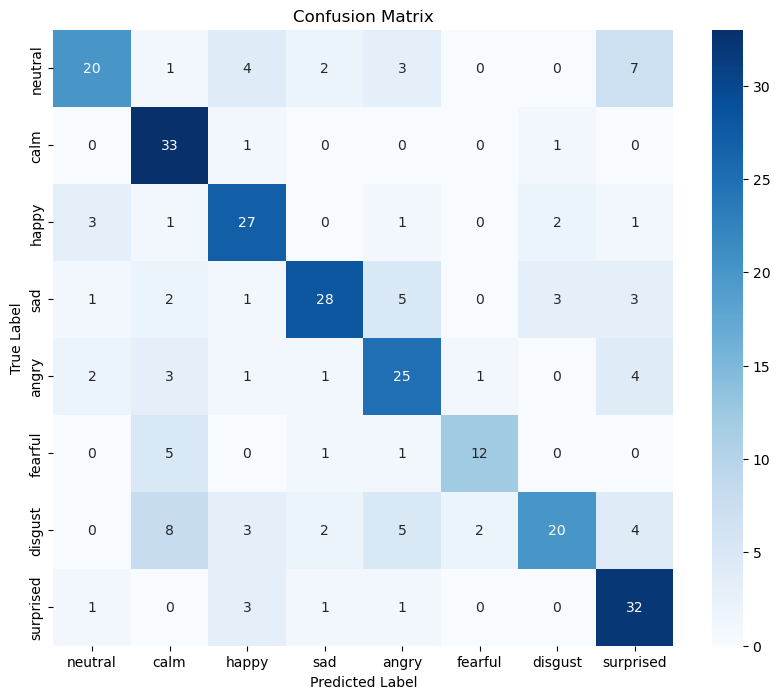

In [15]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = list(emotions.values())

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
# Generate classification report
report = classification_report(y_val, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.74      0.54      0.62        37
        calm       0.62      0.94      0.75        35
       happy       0.68      0.77      0.72        35
         sad       0.80      0.65      0.72        43
       angry       0.61      0.68      0.64        37
     fearful       0.80      0.63      0.71        19
     disgust       0.77      0.45      0.57        44
   surprised       0.63      0.84      0.72        38

    accuracy                           0.68       288
   macro avg       0.71      0.69      0.68       288
weighted avg       0.70      0.68      0.68       288



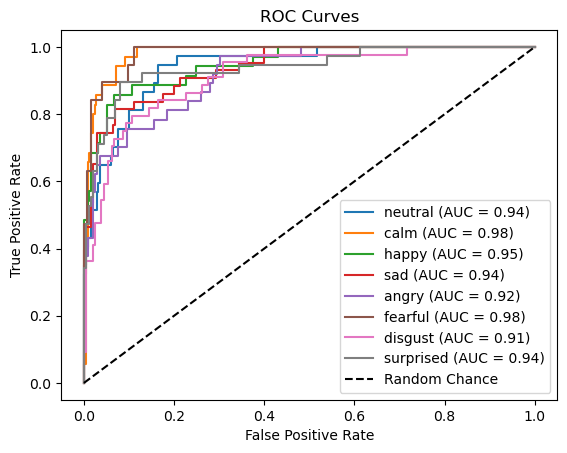

In [17]:
# Binarize labels for ROC-AUC
n_classes = len(labels)
y_val_bin = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()
